In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
df=pd.read_csv('Nifty50.csv',parse_dates=['Date'],index_col='Date')
df = df.loc["2016-01-01" : "2020-12-31"]   #Since 2016-01-01, 5y(1238rows till 2020-12-31), + year 2021's rows
tdf=df.copy()                  #deep copy
df.reset_index(drop=True, inplace=True)

In [48]:
def number_of_years(y):        #calculates the number of years of the dataset
  p=y.index[0]                 #date of first row in the dataset (datetime format)
  q=y.index[len(y)-1]          #date of last row in the dataset  (datetime format)
  return ((q-p).days+1)/365           #the difference give the number of total days (not trading days) over the total number of years in the dataset

In [49]:
trading_days=len(df)/number_of_years(tdf)                       #Trading days per year (automated)

In [50]:
returnsh=df.pct_change()                  #Here, returnsh would mean return considered for sharpe ratio
returnsh.fillna(0,inplace=True)           #calculating daily returns of the stocks in the portfolio

In [51]:
returnso=returnsh.copy()                  #this cell considers only NEGATIVE returns so as to calculate sortino ratio
for cols in returnso.columns.tolist():
    for i in range(0,len(df)):
      if returnso[cols][i] > 0:
        returnso[cols][i]=0               #Here, returnso would mean return considered for sortino ratio

In [52]:
covmatsh=returnsh.cov()*trading_days      #Annualised covariance matrix calculated wrt returnsh i.e. used to calculate sharpe ratio
covmatso=returnso.cov()*trading_days      #Annualised covariance matrix calculated wrt returnso i.e. used to calculate sortino ratio

In [53]:
num_portfolios = 50000                   #initializing number of portfolios to 50000; referred from Wang et al (2020) (science direct)
num_assets = len(df.columns)              #initializing number of stocks/assets considered in the portfolio
risk_free_rate = 0.0358                   #initializing risk free rate that will be used in calculating both the ratios (absolute value)
#referred from url: https://www.rbi.org.in/Scripts/BS_NSDPDisplay.aspx?param=4&Id=24292
#In the above url, the 364 (1 year) day treasury bill is 3.58% , when taken absolute value => 0.0358
# (improved)

In [54]:
#2021_chen etal_Mean–variance portfolio optimization using machine learning-based stock price prediction
#Repeat the process 50,000times. From a statistical point of view, 50,000 random portfolios cover most possible portfolios with different weights and aresufficiently representative

In [55]:
portfolio_returns = []                    #initializing an empty list for portfolio returns
portfolio_volatility =[]                  #initializing an empty list for portfolio risk
stock_weights =[]                         #initializing an empty list for portfolio weights
semi_deviation =[]                        #initializing an empty list for portfolio semi-deviation
sharpe =[]                                #initializing an empty list for portfolio sharpe ratio
sortino =[]                               #initializing an empty list for portfolio sortino ratio

In [56]:
def ratio(a,b,c):                         #function to calculate ratio i.e. "(returns-(risk_free_rate))/deviation"
  return (a-c)/b                          #a => annual return, c => risk_free_rate, b => deviation (standard for sharpe, semi for sortino)

In [57]:
for single_portfolio in range(num_portfolios):                  #iterating forloop for 50000 times to generate 50000 portfolios
  weights = np.random.random(num_assets)                        #initializing random weights
  weights /= np.sum(weights)                                    #No Short Selling Allowed => weights add up to 1   "x = x+y" => "x+=y"    weights = weights/np.sum(weights)  
  returns_temp = np.sum(returnsh.mean()*weights)*trading_days   #calculating annulaised portfolio return
  varsh=np.dot(weights.T,np.dot(covmatsh,weights))              #calculating portfolio varience wrt calculating sharpe ratio
  varso=np.dot(weights.T,np.dot(covmatso,weights))              #calculating portfolio varience wrt calculating sortino ratio
  volatility_temp = np.sqrt(varsh)                              #portfolio risk
  semi_temp = np.sqrt(varso)                                    #portfolio semi-deviation
  shtemp = ratio(returns_temp,volatility_temp,risk_free_rate)   #calculating sharpe ratio
  sotemp = ratio(returns_temp,semi_temp,risk_free_rate)         #calculating sortino ratio
  portfolio_returns.append(returns_temp)                       
  portfolio_volatility.append(volatility_temp)
  stock_weights.append(weights)
  sharpe.append(shtemp)
  sortino.append(sotemp)
  semi_deviation.append(semi_temp)

In [58]:
portfolio = {'Returns' : portfolio_returns, 'Standard Deviation' : portfolio_volatility, 'Semi-Deviation' : semi_deviation, 'Sharpe Ratio' : sharpe, 
             'Sortino Ratio' : sortino}    
#here, 'portfolio' is a dictionary which will be used to create dataframe where each row will be a portfolio

In [59]:
for counter,symbol in enumerate(df.columns):
  portfolio[symbol + " Weight"] = [Weight[counter] for Weight in stock_weights] 
#to the dictionary (named 'portfolio'), weights for each symbol are added in so as to be displayed in the dataframe

In [60]:
pc = pd.DataFrame(portfolio)         #making the final dataframe where data of 50000 portfolios is appended (subject to be saved, whose code is to be written)

In [61]:
pc=pc*100                                       #Converting everything to percentage
pc['Sharpe Ratio']=pc['Sharpe Ratio']/100       #leaving ratios as it is
pc['Sortino Ratio']=pc['Sortino Ratio']/100

In [62]:
pc.to_csv('portfolios_by_MV.csv')  #saving the portfolios data

In [63]:
max_sharpe=pc['Sharpe Ratio'].max()                                             #Best optimised portfolio wrt sharpe ratio
max_sharpe_portfolio=pc.loc[pc['Sharpe Ratio'] == max_sharpe]
max_sharpe_portfolio

,Returns,Standard Deviation,Semi-Deviation,Sharpe Ratio,Sortino Ratio,Adj Close Weight
0,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
1,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
2,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
3,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
4,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
...,...,...,...,...,...,...
49995,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
49996,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
49997,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
49998,13.339271,17.98775,12.072388,0.542551,0.808396,100.0


In [64]:
max_sortino=pc['Sortino Ratio'].max()                                            #Best optimised portfolio wrt sortino ratio
max_sortino_portfolio=pc.loc[pc['Sortino Ratio'] == max_sortino]
max_sortino_portfolio

,Returns,Standard Deviation,Semi-Deviation,Sharpe Ratio,Sortino Ratio,Adj Close Weight
0,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
1,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
2,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
3,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
4,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
...,...,...,...,...,...,...
49995,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
49996,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
49997,13.339271,17.98775,12.072388,0.542551,0.808396,100.0
49998,13.339271,17.98775,12.072388,0.542551,0.808396,100.0


In [21]:
#code for visualization is to be written

In [65]:
pc_sharpe=pc.drop(columns=['Sortino Ratio','Semi-Deviation'])

In [66]:
pc_sharpe_top10=pc_sharpe.sort_values(by=['Sharpe Ratio'],ascending=False).head(10)

In [67]:
pc_sharpe_top10.to_csv('Sharpe_Top10_MV.csv')

In [68]:
pc_sharpe_bottom10=pc_sharpe.sort_values(by=['Sharpe Ratio'],ascending=False).tail(10)

In [69]:
pc_sharpe_bottom10.to_csv('Sharpe_Bottom10_MV.csv')

In [70]:
pc_sharpe_bottom10


,Returns,Standard Deviation,Sharpe Ratio,Adj Close Weight
16663,13.339271,17.98775,0.542551,100.0
16664,13.339271,17.98775,0.542551,100.0
16665,13.339271,17.98775,0.542551,100.0
16666,13.339271,17.98775,0.542551,100.0
16667,13.339271,17.98775,0.542551,100.0
16668,13.339271,17.98775,0.542551,100.0
16669,13.339271,17.98775,0.542551,100.0
16670,13.339271,17.98775,0.542551,100.0
16671,13.339271,17.98775,0.542551,100.0
49999,13.339271,17.98775,0.542551,100.0


In [71]:
pc_sharpe_top10

,Returns,Standard Deviation,Sharpe Ratio,Adj Close Weight
0,13.339271,17.98775,0.542551,100.0
33350,13.339271,17.98775,0.542551,100.0
33328,13.339271,17.98775,0.542551,100.0
33329,13.339271,17.98775,0.542551,100.0
33330,13.339271,17.98775,0.542551,100.0
33331,13.339271,17.98775,0.542551,100.0
33332,13.339271,17.98775,0.542551,100.0
33333,13.339271,17.98775,0.542551,100.0
33334,13.339271,17.98775,0.542551,100.0
33335,13.339271,17.98775,0.542551,100.0


In [72]:
sharpe_optimal_portfolio=pc_sharpe_top10.head(1)

In [73]:
sharpe_optimal_portfolio.to_csv('Sharpe_Optimal_MV.csv')

In [74]:
sharpe_optimal_portfolio.T

,0
Returns,13.339271
Standard Deviation,17.987750
Sharpe Ratio,0.542551
Adj Close Weight,100.000000


In [75]:
pc_sortino=pc.drop(columns=['Sharpe Ratio','Standard Deviation'])

In [76]:
pc_sortino_top10=pc_sortino.sort_values(by=['Sortino Ratio'],ascending=False).head(10)

In [77]:
pc_sortino_top10.to_csv('Sortino_Top10_MV.csv')

In [78]:
pc_sortino_top10

,Returns,Semi-Deviation,Sortino Ratio,Adj Close Weight
0,13.339271,12.072388,0.808396,100.0
33350,13.339271,12.072388,0.808396,100.0
33328,13.339271,12.072388,0.808396,100.0
33329,13.339271,12.072388,0.808396,100.0
33330,13.339271,12.072388,0.808396,100.0
33331,13.339271,12.072388,0.808396,100.0
33332,13.339271,12.072388,0.808396,100.0
33333,13.339271,12.072388,0.808396,100.0
33334,13.339271,12.072388,0.808396,100.0
33335,13.339271,12.072388,0.808396,100.0


In [79]:
pc_sortino_bottom10=pc_sortino.sort_values(by=['Sortino Ratio'],ascending=False).tail(10)

In [80]:
pc_sortino_bottom10.to_csv('Sortino_Bottom10_MV.csv')

In [81]:
pc_sortino_bottom10

,Returns,Semi-Deviation,Sortino Ratio,Adj Close Weight
16663,13.339271,12.072388,0.808396,100.0
16664,13.339271,12.072388,0.808396,100.0
16665,13.339271,12.072388,0.808396,100.0
16666,13.339271,12.072388,0.808396,100.0
16667,13.339271,12.072388,0.808396,100.0
16668,13.339271,12.072388,0.808396,100.0
16669,13.339271,12.072388,0.808396,100.0
16670,13.339271,12.072388,0.808396,100.0
16671,13.339271,12.072388,0.808396,100.0
49999,13.339271,12.072388,0.808396,100.0


In [82]:
sortino_optimal_portfolio=pc_sortino_top10.head(1)

In [83]:
sortino_optimal_portfolio.to_csv('Sortino_Optimal_MV.csv')

In [84]:
sortino_optimal_portfolio.T

,0
Returns,13.339271
Semi-Deviation,12.072388
Sortino Ratio,0.808396
Adj Close Weight,100.000000


## graphs


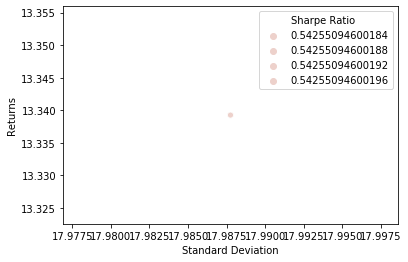

In [85]:
sns.scatterplot(x=pc_sharpe['Standard Deviation'],y=pc_sharpe['Returns'],hue=pc_sharpe['Sharpe Ratio'])

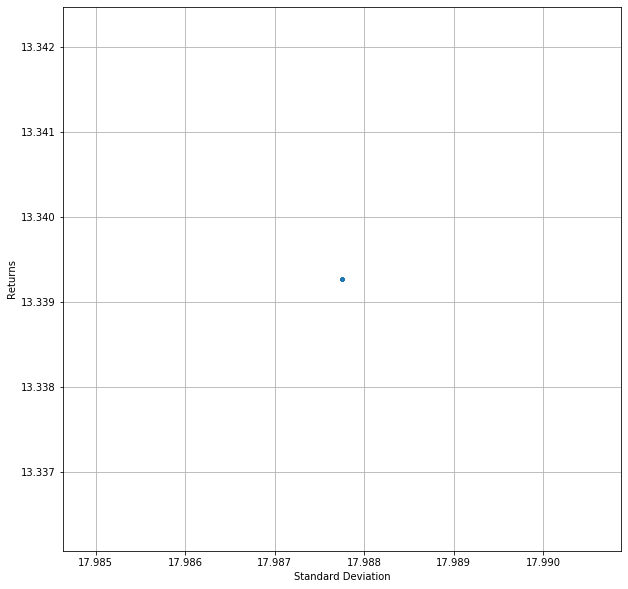

In [86]:
pc_sharpe.plot.scatter(x='Standard Deviation',y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])


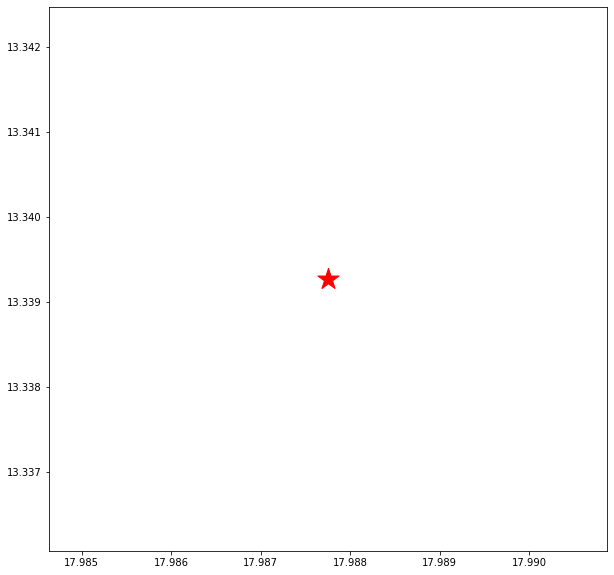

In [87]:
plt.subplots(figsize=[10,10])
plt.scatter(x=pc_sharpe['Standard Deviation'],y=pc_sharpe['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(x=sharpe_optimal_portfolio['Standard Deviation'],y=sharpe_optimal_portfolio['Returns'], color='r', marker='*', s=500)


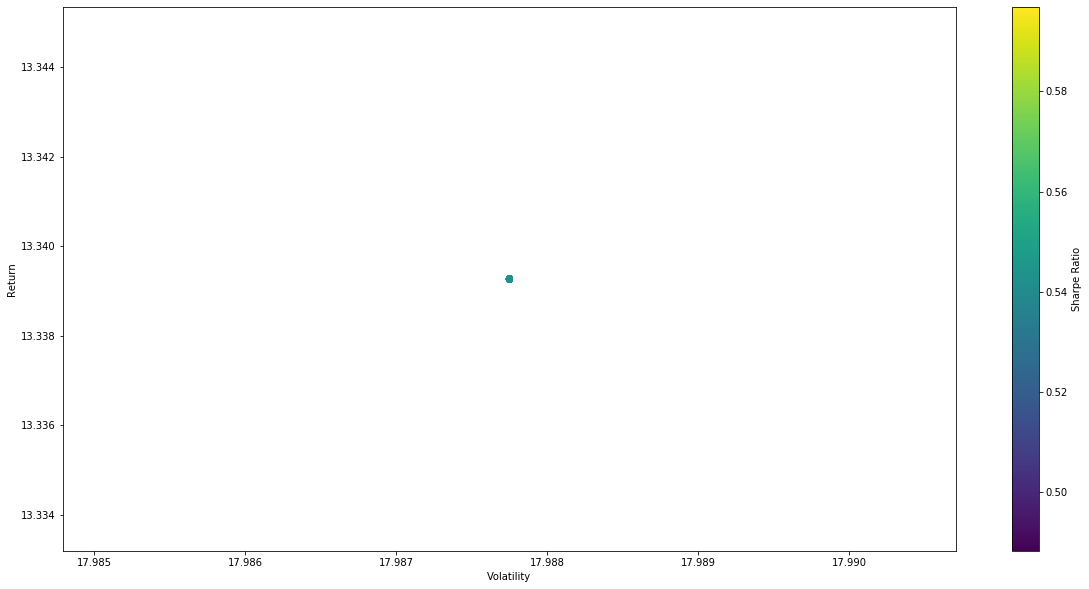

In [88]:
plt.figure(figsize=(20,10))
plt.scatter(pc_sharpe['Standard Deviation'],pc_sharpe['Returns'], c=pc_sharpe['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

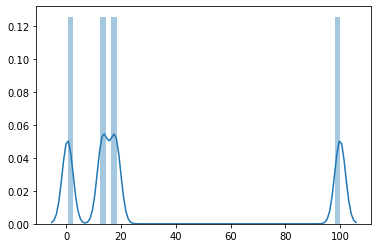

In [89]:
sns.distplot(pc_sharpe)